In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import re
from textblob import TextBlob
from time import time
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
import numpy as np
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
'''
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
'''

'\nhttps://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e\nhttps://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0\nhttps://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e\nhttps://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114\n'

In [0]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Proj/loansTest.csv")
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Proj/loansTrain.csv")

In [0]:
# extract feature columns
feature_cols = list(train.columns[:-1])
# extract target column 'loan_status'
target_col = train.columns[-1]

# separate the data into feature data and target data
X_all = train[feature_cols]
y_all = train[target_col]

# extract feature columns
feature_cols = list(test.columns[1:])
# extract target column 'loan_status'
target_col = test.columns[0]

# separate the data into feature data and target data
X_test = test[feature_cols]
id_test = test[target_col]

X_all = pd.concat([X_all, X_test], ignore_index=True, sort=False)

In [0]:
def preprocess_features(X):
    ''' Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        print(col)
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Feature Engineering

In [0]:
toBeTransform = ['mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_recent_inq']
# to help normalizing the magnitude diffrences in time related features
for t in toBeTransform:
    X_all[t] = (X_all[t]+1).transform(np.log)


In [0]:
# There are too many non competable employment titles
X_all['emp_title'].unique()

array(['Cardiac cath lab tech', 'City of Platte City', nan, ...,
       'Claims assistant specialist', 'HANY', 'Mental Health Teck'],
      dtype=object)

We notice that it contains categorical values. After using X_all['emp_title'].unique() , we notice that the values of the emp_title are repeated in a way. So we are trying to combine repeated values.

In [0]:
# all missing values unemployed
X_all['emp_title'].fillna("unemployed",inplace=True)

# all titles lower case
X_all['emp_title'].str.lower()

# Replace non-alphanumeric
X_all['emp_title'] = X_all['emp_title'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)

# fix spelling mistakes
#X_all['emp_title'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

frequent_titles = pd.Series(' '.join(X_all['emp_title']).lower().split()).value_counts()[:200]
arr = frequent_titles.index.to_numpy()

to_be_ignored = ['the', 'of', 'and', '&', 'city', '-', '/','sr.', 'sr','inc.']

for ingnore in to_be_ignored:
    arr = np.delete(arr, np.argwhere(arr == ingnore))

# Feature Transformation

whole = '|'.join(arr)
arr = map(lambda x:[x, re.compile('.*'+ x +'.*')], arr )

for r in arr:
    print('.',end="")
    X_all['emp_title'] = X_all['emp_title'].str.replace(r[1], r[0], regex=True)
    
# renaming everything else to 'other'
X_all['emp_title'] = np.where(~X_all['emp_title'].str.contains(whole), 'other', X_all['emp_title'])



...................................................................................................................................................................................................

In [0]:
# feature removel
# X_all.drop(['zip_code', 'addr_state', 'earliest_cr_line'], axis=1, inplace=True)
# feature removel
# X_all.drop(['zip_code', 'dti', 'avg_cur_bal','application_type','emp_title','chargeoff_within_12_mths','acc_now_delinq', 'delinq_amnt','percent_bc_gt_75','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','tax_liens'], axis=1, inplace=True)

In [0]:
# Dropping columns with missing value rate higher than threshold
X_all = X_all[X_all.columns[X_all.isnull().mean() < 0.7]]

# replace null with zeros
for col in X_all.columns:
    # Replacing the missing values with the maximum occurred value 
    X_all[col].fillna(X_all[col].value_counts().idxmax(), inplace=True)
    #X_all[col].fillna(0,inplace=True) 
    
    # removing trailing whitespaces and making all lowercase
    if X_all[col].dtype == np.object:
        X_all[col].str.strip()
        X_all[col].str.lower()

In [0]:
# Convert categorical variable into dummy/indicator variables
X_all['term'] = X_all['term'].replace(['36 months', '60 months'], [0, 1])
X_all['term'] = X_all['term'].replace([' 36 months', ' 60 months'], [0, 1])
X_all['verification_status'] = pd.get_dummies(X_all['verification_status'], prefix = 'verification_status')  
X_all['purpose'] = pd.get_dummies(X_all['purpose'], prefix = 'purpose')  
X_all['application_type'] = pd.get_dummies(X_all['application_type'], prefix = 'application_type')  
# X_all['emp_title'] = pd.get_dummies(X_all['emp_title'], prefix = 'emp_title')  

# Drop less necessery features
X_all.drop(['zip_code', 'earliest_cr_line','avg_cur_bal','chargeoff_within_12_mths','acc_now_delinq','percent_bc_gt_75','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','tax_liens'], axis=1, inplace=True)

X_all = preprocess_features(X_all)

loan_amnt
term
grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
purpose
addr_state
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
collections_12_mths_ex_med
application_type
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
bc_open_to_buy
bc_util
delinq_amnt
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_inq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_op_past_12m
pct_tl_nvr_dlq
pub_rec_bankruptcies
tot_hi_cred_lim
total_bal_ex_mort
total_il_high_credit_limit


In [0]:
X, X_test = X_all.iloc[:1000000,:], X_all.iloc[1000000:,:]

X_train, X_val, y_train, y_val = train_test_split(X, y_all, train_size=0.05, random_state=1)

# Univariate Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable. Chi-squared (chi²) statistical test is being used to select 10 of the best features 

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                          Specs         Score
258             tot_hi_cred_lim  4.283441e+07
233                 tot_cur_bal  3.333256e+07
236              bc_open_to_buy  6.859597e+06
169                  annual_inc  6.029243e+06
234            total_rev_hi_lim  3.961914e+06
0                     loan_amnt  1.024050e+06
228                   revol_bal  3.896896e+05
260  total_il_high_credit_limit  1.080002e+05
259           total_bal_ex_mort  8.555409e+04
238                 delinq_amnt  4.673447e+04
237                     bc_util  4.060939e+03
223                         dti  2.477249e+03
229                  revol_util  2.132593e+03
232                tot_coll_amt  1.507967e+03
235        acc_open_past_24mths  1.155612e+03
2                       grade_A  1.087639e+03
1                          term  1.076925e+03
6                       grade_E  7.328735e+02
255          num_tl_op_past_12m  6.234412e+02
242                    mort_acc  5.163960e+02


# Feature Importence
Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[2.09364986e-02 1.56509413e-02 1.77319307e-02 1.00262742e-02
 7.79517008e-03 8.74050180e-03 8.81720972e-03 5.12948426e-03
 2.19948446e-03 7.08247583e-04 1.85347074e-04 2.14259785e-04
 2.16921551e-04 4.41804863e-04 0.00000000e+00 9.23316980e-04
 4.97199825e-04 1.60904262e-04 3.77286260e-04 2.74770951e-04
 4.48548330e-05 8.38164430e-05 4.54487789e-04 6.02633467e-04
 1.14593982e-04 3.04044871e-04 2.07173098e-04 3.20940354e-05
 0.00000000e+00 1.92977647e-04 9.77888239e-05 0.00000000e+00
 6.64808495e-04 0.00000000e+00 9.08857207e-05 3.59151558e-03
 2.93278339e-05 6.28614459e-05 1.12593251e-04 2.02260985e-04
 1.98125902e-04 2.36648051e-04 4.30077819e-06 1.58457899e-05
 6.69624249e-04 3.49590725e-06 1.92471172e-03 3.87875872e-06
 1.86692545e-04 5.44645229e-04 3.98991340e-05 7.91018015e-05
 1.23053322e-04 0.00000000e+00 2.48466759e-05 6.85765876e-05
 3.81541272e-04 7.71403488e-05 3.12452963e-06 2.27676857e-05
 1.69162521e-04 6.19642659e-05 2.55332997e-04 1.29030025e-06
 7.84330184e-05 1.040273

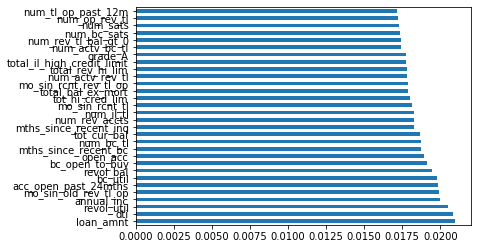

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [0]:
# Feature Importence with random forest
clf = RandomForestClassifier(n_jobs=-1)
clf = clf.fit(X_train, y_train)
fti = clf.feature_importances_
for i, feat in enumerate(X_train.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

model = SelectFromModel(clf, prefit=True)
train_new = model.transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


	loan_amnt            : 0.030308
	term                 : 0.016058
	grade_A              : 0.013106
	grade_B              : 0.009181
	grade_C              : 0.004813
	grade_D              : 0.005863
	grade_E              : 0.007305
	grade_F              : 0.003837
	grade_G              : 0.001846
	emp_title_2          : 0.000387
	emp_title_admin      : 0.000121
	emp_title_advisor    : 0.000090
	emp_title_agent      : 0.000081
	emp_title_analyst    : 0.000280
	emp_title_area       : 0.000000
	emp_title_assistant  : 0.000368
	emp_title_associate  : 0.000196
	emp_title_asst       : 0.000035
	emp_title_attendant  : 0.000217
	emp_title_bank       : 0.000069
	emp_title_billing    : 0.000030
	emp_title_branch     : 0.000021
	emp_title_care       : 0.000178
	emp_title_carrier    : 0.000251
	emp_title_case       : 0.000057
	emp_title_cashier    : 0.000117
	emp_title_center     : 0.000063
	emp_title_ceo        : 0.000000
	emp_title_certified  : 0.000000
	emp_title_chef       : 0.000132
	emp_title

# Collinear Features
Collinear features are features that are highly correlated with one another. In machine learning, these lead to decreased generalization performance on the test set due to high variance and less model interpretability.

In [0]:
# Create correlation matrix
corr_matrix = X_all.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

X_all.drop(X_all[to_drop], axis=1)

,loan_amnt,term,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_title_2,emp_title_admin,emp_title_advisor,emp_title_agent,emp_title_analyst,emp_title_area,emp_title_assistant,emp_title_associate,emp_title_asst,emp_title_attendant,emp_title_bank,emp_title_billing,emp_title_branch,emp_title_care,emp_title_carrier,emp_title_case,emp_title_cashier,emp_title_center,emp_title_ceo,emp_title_certified,emp_title_chef,emp_title_chief,emp_title_claims,emp_title_clerk,emp_title_client,emp_title_clinical,emp_title_co,emp_title_data,emp_title_dental,emp_title_department,emp_title_dept,...,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,collections_12_mths_ex_med,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,total_bal_ex_mort,total_il_high_credit_limit
0,30800,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,25.70,1.0,1.0,6.0,0.0,8343,79.5,0.0,1,0.0,154323.0,10500.0,7.0,2157.0,79.5,0.0,4.262680,1.098612,1.098612,1.0,1.098612,1.098612,0.0,1.0,1.0,2.0,5.0,8.0,2.0,5.0,2.0,92.3,0.0,55725.0,57234.0
1,15000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14.04,0.0,2.0,10.0,0.0,9448,55.3,0.0,1,0.0,0.0,10000.0,3.0,0.0,0.0,0.0,4.890349,1.098612,1.098612,0.0,1.386294,0.693147,0.0,3.0,4.0,3.0,5.0,4.0,6.0,10.0,1.0,100.0,0.0,0.0,0.0
2,3200,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7.84,0.0,0.0,4.0,0.0,6982,61.8,0.0,1,0.0,12505.0,11300.0,1.0,4318.0,61.8,0.0,5.288267,2.833213,2.833213,0.0,2.833213,0.693147,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,100.0,0.0,12505.0,5500.0
3,10000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7.37,0.0,1.0,12.0,0.0,24022,77.5,0.0,1,0.0,265667.0,31000.0,2.0,6978.0,77.5,0.0,4.852030,3.871201,2.708050,3.0,3.871201,1.098612,0.0,3.0,3.0,3.0,7.0,8.0,5.0,10.0,0.0,100.0,0.0,77238.0,55217.0
4,34275,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14.86,0.0,1.0,17.0,0.0,27551,55.5,0.0,1,0.0,43252.0,49600.0,3.0,17952.0,59.7,0.0,4.477337,2.890372,2.397895,0.0,2.890372,1.609438,0.0,9.0,11.0,13.0,16.0,1.0,16.0,21.0,1.0,100.0,0.0,43252.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303600,11500,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,14.95,0.0,2.0,9.0,1.0,6494,94.1,0.0,1,0.0,185568.0,6900.0,1.0,265.0,95.9,0.0,4.442651,1.609438,1.609438,1.0,1.609438,1.386294,0.0,5.0,6.0,5.0,5.0,4.0,6.0,6.0,1.0,100.0,1.0,43180.0,50127.0
1303601,16875,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17.03,0.0,0.0,12.0,0.0,18744,63.0,1.0,1,0.0,244044.0,29550.0,7.0,1910.0,99.0,0.0,5.303305,1.609438,1.609438,1.0,1.945910,2.079442,1.0,5.0,9.0,6.0,6.0,2.0,9.0,11.0,5.0,93.0,0.0,45132.0,43283.0
1303602,9175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,17.91,0.0,1.0,13.0,0.0,6440,84.0,0.0,1,0.0,40996.0,7660.0,7.0,1500.0,93.0,0.0,5.420535,1.098612,1.098612,3.0,1.098612,1.098612,6.0,3.0,6.0,3.0,3.0,12.0,6.0,7.0,1.0,61.0,0.0,40996.0,40788.0
1303603,6700,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,33.97,0.0,3.0,21.0,0.0,5624,36.1,0.0,1,0.0,2

# Compare Classifiers
Choose the classifier that gives the best F1 score on validation data.

In [0]:
names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost","RandomForestRegresor"]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    RandomForestRegressor(max_depth=5, n_estimators=100, max_features=1)]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    print(name, ":", score)

Decision Tree : 0.7989547368421053
Random Forest : 0.7993210526315789
Neural Net : 0.799318947368421
AdaBoost : 0.8018778947368421
RandomForestRegresor : 0.007392667004468167


In [0]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds",format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

# Choosing best hyperparamters for RandomForrestClassifier


- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)
- Method of selecting samples for training each tree



In [0]:
parameters = {
    # Number of trees in random forest
    'n_estimators'      : [350,400,450],
    # Maximum number of levels in tree
    'max_depth'         : [12, 18, 30, 48, 78],
    'random_state'      : [48],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt'],
    # Minimum number of samples required to split a node
    'min_samples_split' : [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf' : [1, 2, 4]
}
scorer = make_scorer(f1_score)
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 1000 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters,scoring = scorer,  cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_fit = rf_random.fit(X_train, y_train)

print(rf_fit.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


{'random_state': 48, 'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 48}


Found the best Hyperparameters. And now evaluating this model using K-fold cross validation.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y_all, train_size=0.95, random_state=1)

In [0]:
ideal = {
    'max_depth': 48, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 4, 
    'random_state' : 48,
    'min_samples_split': 2, 
    'n_estimators': 350, 
    'n_jobs':-1,
}

rf = RandomForestClassifier(**ideal)

In [0]:
train_predict(rf, X_train, y_train, X_val, y_val)

Training a RandomForestClassifier using a training set size of 950000. . .
Trained model in {:.4f} seconds 131.93768191337585
Made predictions in 12.3170 seconds.
F1 score for training set: 0.9218.
Made predictions in 0.7808 seconds.
F1 score for test set: 0.8908.


In [0]:
y_pred = rf.predict(X_test)
loan = pd.DataFrame({'loan_status': y_pred[:]})
result = pd.concat([id_test,loan], axis=1, sort=False)
result.to_csv('/content/drive/My Drive/Colab Notebooks/Proj/result.csv', index=False)